In [1]:
import torch
import numpy as np
import math

train_result = torch.load('./train_result.pt')
I_gen = train_result['I'].numpy()


In [ ]:
import numpy as np
import cv2
from lens_distort import lensdistort 
 
num = 1000
wl = [450.0e-9, 532.0e-9, 635.0e-9]

# Source images
img_dir = './source_image/'
original_img = ['w_Blue.png', 'w_Green.png', 'w_Red.png']
I_source = np.zeros([num, num, 3])
for i in range(3):
    f_img = original_img[i]
    ratio = wl[0] / wl[i] 
    I = cv2.imread(img_dir + f_img, cv2.IMREAD_GRAYSCALE)
    I = cv2.resize(I, (num, num))
    I = cv2.resize(I, (int(num * ratio), int(num * ratio)))
    if I.shape[0] % 2 == 1:
        I_temp = np.zeros([I.shape[0]+1, I.shape[0]+1])
        I_temp[1:, 1:] = I
        I = I_temp
    I = np.pad(I, ((num- I.shape[0])//2, (num - I.shape[0])//2), 'constant', constant_values=(0, 0))
    I = I / np.max(I)
    I = I[:, ::-1]
        
    clev = 0.6
    I = lensdistort(I,clev, ftype=3, bordertype='fit')    # "lensdistort" is a help function
    for idx1 in range(num):
        for idx2 in range(num):
            if idx1 < 40 or idx1 > (num-40) or idx2 < 40 or idx2 > (num-40):   # boundaries can be changed after checking "compensated_img"
                I[idx1, idx2] = 0                 # removal of white edges
    I[I<0] = 0                              # removal of negative values
    I = I/np.max(I)                         # renormalization
    
    I_source[:, :, i] = I            # BGR to RGB

    

(700, 700, 3)


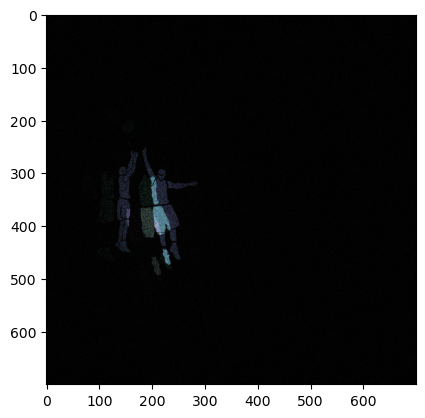

In [38]:
import matplotlib.pyplot as plt
# img_gen = cv2.cvtColor(I_gen, cv2.COLOR_BGR2RGB)
# img_source = cv2.cvtColor(I_source, cv2.COLOR_BGR2RGB)
plt.imshow(I_gen[:, :, :])
print(I_gen.shape)
# print(I_source.shape)
# plt.imshow(I_gen)


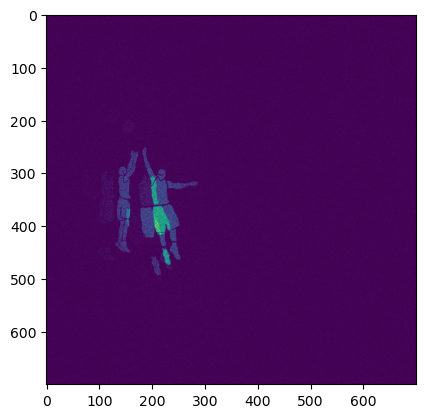

In [36]:
plt.imshow(I_gen[:, :, 2])

In [6]:
# import pandas as pd

# def highlight(val):
#     crit = 0.3
#     is_above = val > crit
#     return ['background-color: yellow' if v else '' for v in is_above]

# # Mask to csv
# def mask2csv(img, filename):
#     df = pd.DataFrame(img)
#     df.style.apply(highlight).to_excel(filename + '.xlsx', header=False, index=False)
    
# mask2csv(I_source[:,:,0], 'source_mask_blue')

In [24]:
# Loss functions

def Match_loss(I, target_img, i):
    metric = torch.nn.MSELoss()
    match_weight = 1000.0; unmatch_weight = 2e-4
    num_wl= I.shape[2]
    
    crit = 0.3
    mask_i = torch.where(target_img[:, :, i] > crit, 1, 0)
    rev_mask_i = torch.where(target_img[:, :, i] > crit, 0, 1)
    
    I_i = I[:,:,i]
    target_i = target_img[:,:,i]
    avg_target_i = torch.mean(target_i)
    avg_I = torch.mean(I_i)
    norm_I_i = avg_target_i * I_i / avg_I
    match_loss = match_weight * metric((mask_i * norm_I_i), target_i) / num_wl
    unmatch_loss = unmatch_weight * torch.sum(rev_mask_i * norm_I_i)
    return match_loss, unmatch_loss


def Norm_loss(I, target_img, i):
    metric = torch.nn.MSELoss()
    batch_weights = [2, 1, 1]
    target_i = target_img[:,:,i]
    avg_target_i = torch.mean(target_i)
    I_i = I[:,:,i]
    avg_I = torch.mean(I_i)
    norm_I_i = avg_target_i * I_i / avg_I
    norm_loss = (batch_weights[i] / len(batch_weights)) * metric(norm_I_i, target_i)
    
    return norm_loss


In [25]:
# I_gen: Image generated by end-to-end model
# I_source: Source images
I_gen = torch.tensor(I_gen)
I_source = torch.tensor(I_source)
I_zeros = 1e-4*torch.ones_like(I_gen)
# I_zeros = torch.zeros_like(I_gen)


/tmp/ipykernel_276448/2822759139.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_gen = torch.tensor(I_gen)
/tmp/ipykernel_276448/2822759139.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_source = torch.tensor(I_source)


In [34]:
def print_losses(I, I_target, i, name):
    # With generated image
    match_loss, unmatch_loss = Match_loss(I, I_target, i)
    norm_loss = 1000 * Norm_loss(I, I_target, i)
    # With zeros
    I_zeros = 1e-4*torch.ones_like(I_gen)
    match_loss_zero, unmatch_loss_zero = Match_loss(I_zeros, I_target, i)
    norm_loss_zero = 1000 * Norm_loss(I_zeros, I_target, i)
    print(name)
    print(f"\tMatch Loss")
    print(f"\t\tGen: {match_loss.item(): .2f}, Zero: {match_loss_zero.item(): .2f}")
    print(f"\tUnmatch Loss")
    print(f"\t\tGen: {unmatch_loss.item(): .2f}, Zero: {unmatch_loss_zero.item(): .2f}")
    print(f"\tNorm loss")
    print(f"\t\tGen: {norm_loss.item(): .2f}, Zero: {norm_loss_zero.item(): .2f}")
    print(f"\tTotal loss")
    print(f"\t\tGen: {match_loss.item() + unmatch_loss.item() + norm_loss.item(): .2f}, Zero: {match_loss_zero.item() + unmatch_loss_zero.item() + norm_loss_zero.item(): .2f}")

print_losses(I_gen, I_source, 0, "Blue")
print_losses(I_gen, I_source, 1, "Green")
print_losses(I_gen, I_source, 2, "Red")

Blue
	Match Loss
		Gen:  2.99, Zero:  3.46
	Unmatch Loss
		Gen:  2.20, Zero:  2.37
	Norm loss
		Gen:  6.13, Zero:  7.02
	Total loss
		Gen:  11.32, Zero:  12.86
Green
	Match Loss
		Gen:  4.51, Zero:  5.23
	Unmatch Loss
		Gen:  3.21, Zero:  3.46
	Norm loss
		Gen:  4.69, Zero:  5.33
	Total loss
		Gen:  12.41, Zero:  14.02
Red
	Match Loss
		Gen:  4.62, Zero:  5.46
	Unmatch Loss
		Gen:  3.45, Zero:  3.75
	Norm loss
		Gen:  4.82, Zero:  5.58
	Total loss
		Gen:  12.89, Zero:  14.79
